In [1]:
import PythonicDISORT
from PythonicDISORT.subroutines import _compare
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import pi

Previously saved reference solutions will be loaded if F2PY-wrapped Stamnes' DISORT is unavailable.

In [2]:
disort_is_installed = True
try:
    import disort
except ImportError:
    disort_is_installed = False

# Table of Contents
* [4a and setup](#4a-and-setup)
* [4b](#4b)
* [4c](#4c)


# Test Problem 4:  Haze-L Scattering, Beam Source

Compare to Tables 12 to 16 of Garcia, R.D.M. and C.E. Siewert, 1985: *Benchmark Results in Radiative Transfer, Transport Theory and Statistical Physics* 14, 437-483.

# 4a and setup

**PythonicDISORT**

In [3]:
Leg_coeffs_ALL = np.array([1,
                           2.41260, 3.23047, 3.37296, 3.23150, 2.89350, 
                           2.49594, 2.11361, 1.74812, 1.44692, 1.17714,
                           0.96643, 0.78237, 0.64114, 0.51966, 0.42563,
                           0.34688, 0.28351, 0.23317, 0.18963, 0.15788,
                           0.12739, 0.10762, 0.08597, 0.07381, 0.05828,
                           0.05089, 0.03971, 0.03524, 0.02720, 0.02451,
                           0.01874, 0.01711, 0.01298, 0.01198, 0.00904,
                           0.00841, 0.00634, 0.00592, 0.00446, 0.00418,
                           0.00316, 0.00296, 0.00225, 0.00210, 0.00160,
                           0.00150, 0.00115, 0.00107, 0.00082, 0.00077,
                           0.00059, 0.00055, 0.00043, 0.00040, 0.00031,
                           0.00029, 0.00023, 0.00021, 0.00017, 0.00015,
                           0.00012, 0.00011, 0.00009, 0.00008, 0.00006,
                           0.00006, 0.00005, 0.00004, 0.00004, 0.00003,
                           0.00003, 0.00002, 0.00002, 0.00002, 0.00001,
                           0.00001, 0.00001, 0.00001, 0.00001, 0.00001,
                           0.00001, 0.00001])

######################################### PYDISORT ARGUMENTS #######################################

tau_arr = 1  # One layer of thickness 1 (medium-thick atmosphere)
omega_arr = 1 - 1e-6  # Reduced from 1 (conservative scattering) which is not implemented
NQuad = 32  # 32 streams (16 quadrature nodes for each hemisphere)
Leg_coeffs_all = Leg_coeffs_ALL / (2 * np.arange(83) + 1)  # Haze-L phase function
mu0 = 1  # Cosine of solar zenith angle (directly downwards)
I0 = pi  # Intensity of direct beam
phi0 = pi  # Azimuthal angle of direct beam

# Optional (used)
f_arr = Leg_coeffs_all[NQuad]  # For delta-M scaling (improves accuracy, especially for fluxes)
NT_cor = True  # Turn on NT corrections (improves accuracy of intensity field; no effect on fluxes)

# Optional (unused)
NLeg = None
NLoops = None
b_pos = 0
b_neg = 0
only_flux = False
BDRF_Fourier_modes = []
s_poly_coeffs = np.array([[]])
use_banded_solver_NLayers=10
autograd_compatible=False

####################################################################################################

In [4]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all[: NQuad + 1], # For this test, DISORT strangely does not use all the moments
    mu0, I0, phi0,
    f_arr=f_arr,
    NT_cor=NT_cor
)

**Setup for tests**

In [5]:
# Reorder mu_arr from smallest to largest
reorder_mu = np.argsort(mu_arr)
mu_arr_RO = mu_arr[reorder_mu]

# We may not want to compare intensities around the direct beam
deg_around_beam_to_not_compare = 0
mu_to_compare = (
    np.abs(np.arccos(np.abs(mu_arr_RO)) - np.arccos(mu0)) * 180 / pi
    > deg_around_beam_to_not_compare
)
mu_test_arr_RO = mu_arr_RO[mu_to_compare]

In [6]:
# Number of phi grid points
Nphi = 2
phi_arr = np.random.random(Nphi) * 2 * pi

# tau test points
tau_test_arr = np.array([0, 0.5, 1])
Ntau = len(tau_test_arr)

**Stamnes' DISORT**

In [7]:
# Stamnes' DISORT arguments
nlyr = 1
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = False
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = tau_arr
ssalb = omega_arr
pmom = Leg_coeffs_all.T[: NQuad + 1] # For this test, DISORT strangely does not use all the moments
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 0
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [8]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    results = np.load("Stamnes_results/4a_test.npz")
    # Load saved results from Stamnes' DISORT
    uu = results["uu"]
    flup = results["flup"]
    rfldn = results["rfldn"]
    rfldir = results["rfldir"]
    # Load comparison points
    tau_test_arr = results["tau_test_arr"]
    phi_arr = results["phi_arr"]

**Comparisons**

In [9]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 1.4431202490351477e-05
Difference ratio = 0.9999999962773328

Downward (diffuse) fluxes
Difference = 1.463413472135855e-05
Difference ratio = 8.073451003621748e-06

Direct (downward) fluxes
Difference = 1.3307408042173563e-07
Difference ratio = 6.98378420884403e-08

Intensities

At tau = 1.0
Max pointwise difference = 3.006284135165238e-05
At tau = 0.0
Max pointwise difference ratio = 0.0003987231700518897



**Does the test pass?**

In [10]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/4a_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [11]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

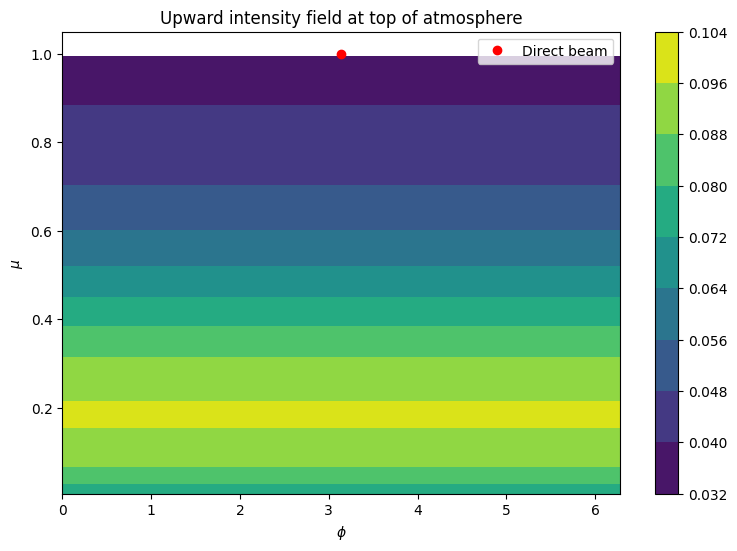

In [12]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.plot(phi0, mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)
plt.legend()

----------

# 4b

**PythonicDISORT**

In [13]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = 1
omega_arr = 0.9
NQuad = 32
Leg_coeffs_all = Leg_coeffs_ALL / (2 * np.arange(83) + 1)
mu0 = 1
I0 = pi
phi0 = pi

# Optional (used)
f_arr = Leg_coeffs_all[NQuad]
NT_cor = True

# Optional (unused)
NLeg=None
NLoops=None
b_pos=0
b_neg=0
only_flux=False
BDRF_Fourier_modes=[]
s_poly_coeffs=np.array([[]])
use_banded_solver_NLayers=10
autograd_compatible=False

####################################################################################################

In [14]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all[: NQuad + 1], # For this test, DISORT strangely does not use all the moments
    mu0, I0, phi0,
    f_arr=f_arr,
    NT_cor=NT_cor
)

**Stamnes' DISORT**

In [15]:
# tau test points
tau_test_arr = np.array([0, 0.5, 1])
Ntau = len(tau_test_arr)

In [16]:
# Stamnes' DISORT arguments
nlyr = 1
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = False
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = tau_arr
ssalb = omega_arr
pmom = Leg_coeffs_all.T[: NQuad + 1] # For this test, DISORT strangely does not use all the moments
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 0
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [17]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    results = np.load("Stamnes_results/4b_test.npz")
    # Load saved results from Stamnes' DISORT
    uu = results["uu"]
    flup = results["flup"]
    rfldn = results["rfldn"]
    rfldir = results["rfldir"]
    # Load comparison points
    tau_test_arr = results["tau_test_arr"]
    phi_arr = results["phi_arr"]

**Comparisons**

In [18]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 1.3204730781035678e-07
Difference ratio = 1.1149316235437782e-06

Downward (diffuse) fluxes
Difference = 2.384185791015625e-06
Difference ratio = 1.9459678272994003e-06

Direct (downward) fluxes
Difference = 1.3307408042173563e-07
Difference ratio = 6.98378420884403e-08

Intensities

At tau = 0.5
Max pointwise difference = 3.040340539106623e-06
At tau = 0.0
Max pointwise difference ratio = 6.7395609172743635e-06



**Does the test pass?**

In [19]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/4b_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [20]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

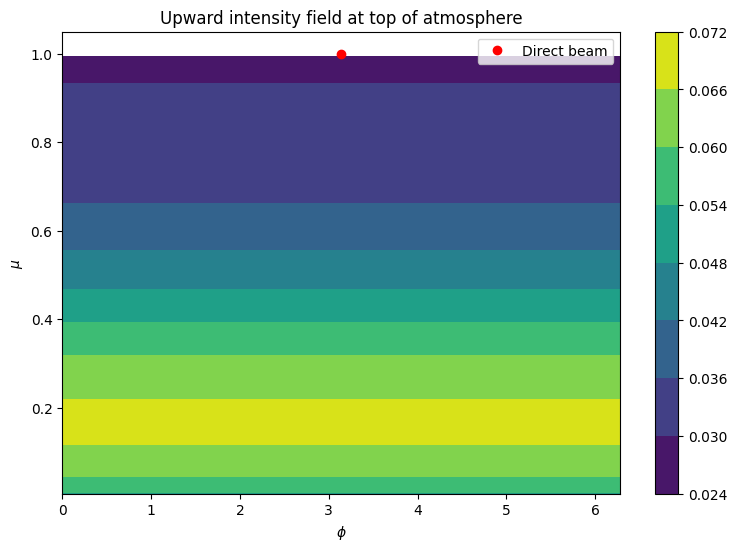

In [21]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.plot(phi0, mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)
plt.legend()

-------

# 4c

**PythonicDISORT**

In [22]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = 1
omega_arr = 0.9
NQuad = 32
Leg_coeffs_all = Leg_coeffs_ALL / (2 * np.arange(83) + 1)
mu0 = 0.5
I0 = pi
phi0 = pi

# Optional (used)
f_arr = Leg_coeffs_all[NQuad]
NT_cor = True

# Optional (unused)
NLeg=None
NLoops=None
b_pos=0
b_neg=0
only_flux=False
BDRF_Fourier_modes=[]
s_poly_coeffs=np.array([[]])
use_banded_solver_NLayers=10
autograd_compatible=False

####################################################################################################

In [23]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all[: NQuad + 1], # For this test, DISORT strangely does not use all the moments
    mu0, I0, phi0,
    f_arr=f_arr,
    NT_cor=NT_cor
)

**Stamnes' DISORT**

In [24]:
# tau test points
tau_test_arr = np.array([0, 0.5, 1])
Ntau = len(tau_test_arr)

In [25]:
# Stamnes' DISORT arguments
nlyr = 1
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = False
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = tau_arr
ssalb = omega_arr
pmom = Leg_coeffs_all.T[: NQuad + 1] # For this test, DISORT strangely does not use all the moments
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 0
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [26]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    results = np.load("Stamnes_results/4c_test.npz")
    # Load saved results from Stamnes' DISORT
    uu = results["uu"]
    flup = results["flup"]
    rfldn = results["rfldn"]
    rfldir = results["rfldir"]
    # Load comparison points
    tau_test_arr = results["tau_test_arr"]
    phi_arr = results["phi_arr"]

**Comparisons**

In [27]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 2.0448572030096202e-07
Difference ratio = 9.068618757326633e-07

Downward (diffuse) fluxes
Difference = 5.960464467075457e-07
Difference ratio = 0.9999999982444983

Direct (downward) fluxes
Difference = 4.371139006309477e-08
Difference ratio = 3.1740779073332835e-08

Intensities

At tau = 0.5
Max pointwise difference = 1.4868562965286714e-06
At tau = 0.5
Max pointwise difference ratio = 2.891097006345467e-05



**Does the test pass?**

In [28]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/4c_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [29]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

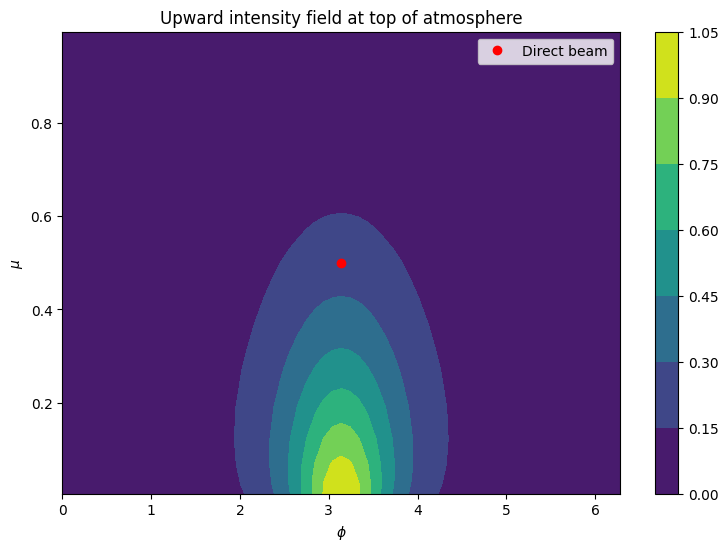

In [30]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.plot(phi0, mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)
plt.legend()

-------